In [1]:
caffe_root = '../caffe'
import sys
sys.path.insert(0, caffe_root + '/python')

import caffe

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import h5py
from matplotlib.patches import Circle
import scipy.io as scio
import os

In [2]:
fx = 588.03
fy = 587.07
ux = 320
uy = 240
def jointsImgTo3D(sample):
    """
    Normalize sample to metric 3D
    :param sample: joints in (x,y,z) with x,y in image coordinates and z in mm
    :return: normalized joints in mm
    """
    ret = np.zeros((sample.shape[0], 3), np.float32)
    for i in range(sample.shape[0]):
        ret[i] = jointImgTo3D(sample[i])
    return ret

def jointImgTo3D(sample):
    """
    Normalize sample to metric 3D
    :param sample: joints in (x,y,z) with x,y in image coordinates and z in mm
    :return: normalized joints in mm
    """
    ret = np.zeros((3,), np.float32)
    # convert to metric using f, see Thomson et al.
    ret[0] = (sample[0] - ux) * sample[2] / fx
    ret[1] = (uy - sample[1]) * sample[2] / fy
    ret[2] = sample[2]
    return ret

def loadPredFile(filepath):
    import os
    assert os.path.isfile(filepath), "{} is not exists or is not a file!".format(filepath)
    with open(filepath, 'r') as f:
        lines = f.readlines()
        for index, line in enumerate(lines):
            lines[index] = map(float, line.split())
        joints = np.array(lines)
        n, d = joints.shape
        return joints.reshape(n, d/3, 3)
    
def getNumFrameWithinMaxDist(gt, joints, dist):
    return (np.nanmax(np.sqrt(np.square(gt - joints).sum(axis=2)), axis=1) <= dist).sum()

def plotAccuracy(gt, joints, thresh = 80, label='ours'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot([getNumFrameWithinMaxDist(gt, joints, j)/ float(joints.shape[0]) * 100. for j in range(0, 80)], label=label)
    ax.grid(True)
    plt.xlabel('Distance threshold / mm')
    plt.ylabel('Fraction of frames within threshold / %')
    plt.xlim((0, 80))
    plt.ylim((0.0, 100.0))

def predict_joints(model_name, weights_num):
    """predict joints"""
    model_def = './hand_' + model_name + '.prototxt'
    model_weights = './weights/hand_' + model_name + '/' + model_name + '_iter_' + weights_num + '.caffemodel'
    if model_name == 'CAE_joint_pre_scratch':
        model_def = './hand_CAE_joint_pre.prototxt'
        model_weights = './weights/hand_' + model_name + '/CAE_joint_pre_iter_' + weights_num + '.caffemodel'
    
    print model_def
    print model_weights
    
    net = caffe.Net(model_def,
                   model_weights,
                   caffe.TEST)

    # store the predicted xyz into files
    image_index = 0
    cube_size = 300
    im_size = 8252
    batch_size = net.blobs['depth'].data.shape[0]
    
    file_name = './result/pred_' + model_name + '_' + weights_num + '.txt'

    import os
    if os.path.isfile(file_name):
        return file_name
    
    pred_file = open(file_name, "w")
    print file_name
                     
    for i in xrange(im_size/batch_size + 1):
        net.forward()
        for j in xrange(batch_size):
            image_index += 1
            if image_index > 2440:
                cube_size = 300 * 0.87
            com = net.blobs['com'].data[j]
            #print "com = ", com
            inds = net.blobs['inds'].data[j]
            #print "image index = ", inds
            pred_joints = net.blobs['joint_pred'].data[j].reshape(14, 3) * cube_size / 2 + com.reshape(1, 3)
            #print "pred joints = ", pred_joints
            for item in pred_joints.reshape(14*3,):
                pred_file.write("%s " %item)
            pred_file.write('\n')
            if image_index == im_size:
                break
        if image_index == im_size:
            break
    pred_file.close()  
    return file_name

def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)

    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

### train

In [ ]:
caffe.set_device(0)
caffe.set_mode_gpu()

solver = None
solver = caffe.AdamSolver('./solver_baseline.prototxt')

solver.net.forward()
solver.test_nets[0].forward()

In [ ]:
img = (solver.net.blobs['depth'].data[0].reshape(128,128))
plt.imshow(img)
(solver.net.blobs['joint'].data[0]).reshape(14,3)

### test

In [3]:
caffe.set_device(0)
caffe.set_mode_gpu()

#### test the autoencoder

In [ ]:
model_def = './hand_CAE.prototxt'
model_weights = './weights/hand_CAE/CAE_iter_90000.caffemodel'
net = caffe.Net(model_def,
               model_weights,
               caffe.TEST)

In [ ]:
net.forward()

## Plot the accuracy of hand pose estimation

### read the ground truth

In [3]:
gt_file = '/mnt/data/NYU-Hands-v2/test/joint_data.mat'
data = scio.loadmat(gt_file)
kinect_index = 0
image_index = 0
joint_uvd = data['joint_uvd'][kinect_index, :, :, :]
joint_xyz = data['joint_xyz'][kinect_index, :, :, :]
restrictedJoint = [0, 3, 6, 9, 12, 15, 18, 21, 24, 25, 27, 30, 31, 32]
joint_name = data['joint_names'].reshape(36, 1)

#### read the prediction(CVWW 2015)

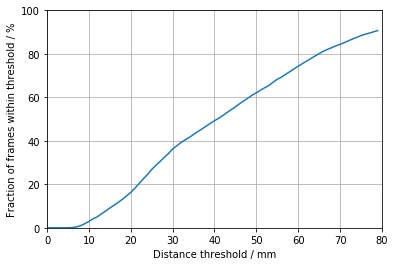

In [4]:
pred_file_CVWW15 = '../result/CVWW15/CVWW15_NYU_Prior.txt'
pred_joints = loadPredFile(pred_file_CVWW15)
pred_joints3D = []
for joints in pred_joints:
    joints3D = jointsImgTo3D(joints)
    pred_joints3D.append(joints3D)
pred_joints3D = np.asarray(pred_joints3D)
plotAccuracy(joint_xyz[:, restrictedJoint], pred_joints3D, label='CVWW15')

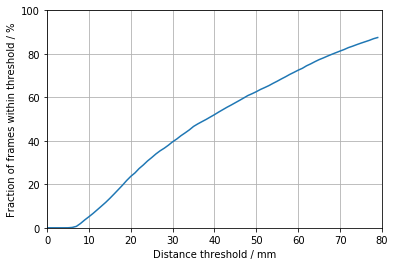

In [17]:
pred_file_CVWW15_refine = '../result/CVWW15/CVWW15_NYU_Prior-Refinement.txt'
pred_joints = loadPredFile(pred_file_CVWW15_refine)
pred_joints3D = []
for joints in pred_joints:
    joints3D = jointsImgTo3D(joints)
    pred_joints3D.append(joints3D)
pred_joints3D = np.asarray(pred_joints3D)
plotAccuracy(joint_xyz[:, restrictedJoint], pred_joints3D, label='CVWW15')

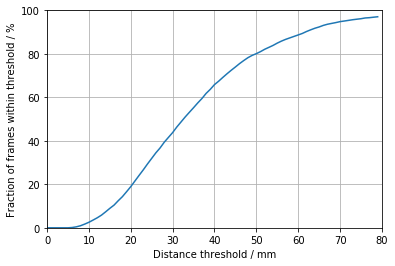

In [20]:
pred_file_ICCV = '../result/ICCV15/ICCV15_NYU_Feedback.txt'
pred_joints = loadPredFile(pred_file_ICCV)
pred_joints3D = []
for joints in pred_joints:
    joints3D = jointsImgTo3D(joints)
    pred_joints3D.append(joints3D)
pred_joints3D = np.asarray(pred_joints3D)
plotAccuracy(joint_xyz[:, restrictedJoint], pred_joints3D, label='ICCV')

In [19]:
pred_joints3D[0]

array([[-188.8598938 ,   48.26607895,  738.2130127 ],
       [-187.65446472,    8.34257603,  753.14099121],
       [-148.77838135,   77.10137939,  739.70300293],
       [-158.14552307,   29.92742729,  758.45001221],
       [-120.9287796 ,   91.98213196,  747.21801758],
       [-131.57484436,   39.8167038 ,  768.39001465],
       [ -91.38425446,   71.44677734,  745.31799316],
       [-103.49025726,   32.36278915,  771.54199219],
       [ -77.93404388,  -13.61524296,  739.690979  ],
       [ -81.0486908 ,  -29.53861618,  752.26599121],
       [ -91.83706665,  -72.48239136,  770.83197021],
       [-182.10557556, -113.22124481,  787.82501221],
       [-147.98939514, -119.26489258,  799.42498779],
       [-144.33244324,  -39.82624817,  782.64697266]], dtype=float32)

In [22]:
pred_joints3D[0]

array([[-188.229  ,   44.5512 ,  733.535  ],
       [-182.629  ,    8.35324,  748.294  ],
       [-149.545  ,   72.9987 ,  735.97   ],
       [-158.274  ,   30.3859 ,  753.725  ],
       [-122.62   ,   86.2346 ,  739.689  ],
       [-135.132  ,   40.1118 ,  762.063  ],
       [ -89.0874 ,   68.4508 ,  744.779  ],
       [-105.313  ,   31.3467 ,  767.451  ],
       [ -71.9281 ,  -13.326  ,  744.801  ],
       [ -80.0219 ,  -30.1785 ,  753.16   ],
       [ -94.1345 ,  -64.798  ,  770.437  ],
       [-174.155  , -108.99   ,  787.732  ],
       [-143.656  , -113.054  ,  797.016  ],
       [-145.196  ,  -36.0952 ,  778.288  ]])

#### predicted by ourselves

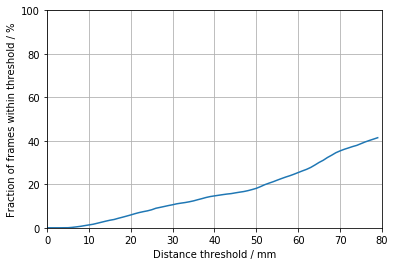

In [21]:
pred_ours_file = '../result/OURS/hand_lstm_160000.txt'
pred_joints3D = loadPredFile(pred_ours_file)

plotAccuracy(joint_xyz[:, restrictedJoint], pred_joints3D, label='CVWW15')

./hand_baseline.prototxt
./weights/hand_baseline/baseline_iter_200000.caffemodel
pred_baseline_200000.txt


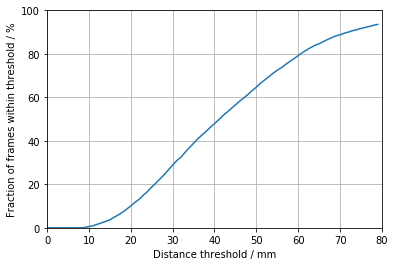

In [17]:
model_num = 'baseline'
weights_num = '200000'
pred_ours_file = predict_joints(model_num, weights_num)
pred_joints = loadPredFile(pred_ours_file)
plotAccuracy(joint_xyz[:, restrictedJoint], pred_joints, label='ours')

./hand_CAE_joint_pre.prototxt
./weights/hand_CAE_joint_pre_scratch/CAE_joint_pre_iter_200000.caffemodel
./result/pred_CAE_joint_pre_scratch_200000.txt


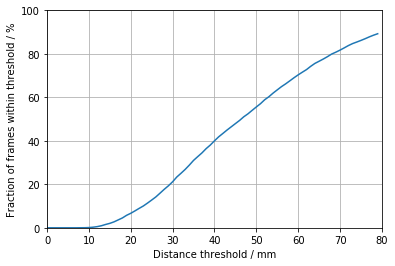

In [25]:
model_name = 'CAE_joint_pre_scratch'
weights_num = '200000'
pred_ours_file = predict_joints(model_name, weights_num)
pred_joints = loadPredFile(pred_ours_file)
plotAccuracy(joint_xyz[:, restrictedJoint], pred_joints, label='ours')

./hand_CAE_joint_pre.prototxt
./weights/hand_CAE_joint_pre/CAE_joint_pre_iter_200000.caffemodel


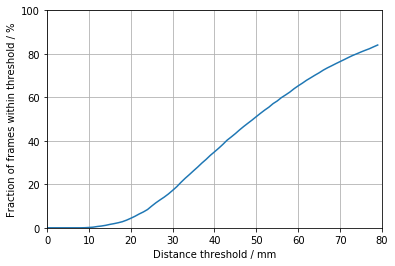

In [28]:
model_name = 'CAE_joint_pre'
weights_num = '200000'
pred_ours_file = predict_joints(model_name, weights_num)
pred_joints = loadPredFile(pred_ours_file)
plotAccuracy(joint_xyz[:, restrictedJoint], pred_joints, label='ours')